In [80]:
#imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

#setings
#username:povergrrr
#key:4ab9a2b112addb191cdbdf82bacaae50
dataset_kaggle = "https://www.kaggle.com/oracledevrel/"
dataset_folder = "formulaaihackathon2022"
dataset_uri = dataset_kaggle+dataset_folder
dataset_file = dataset_folder + "/weather.csv"
DATATYPE = "datetime64[ns]"
FORMAT = '%Y-%m.%d %H:%M:%S'
DECISION = ['M_AIR_TEMPERATURE','M_TRACK_TEMPERATURE','M_RAIN_PERCENTAGE']
TIMESTAMP = 'TIMESTAMP'
WINDOW_SIZE = 5
columns = [
            'TIMESTAMP',
            'M_SESSION_UID',
            'M_TRACK_ID',
            'M_TRACK_TEMPERATURE', #wywalone bo ma 98% korelacji z M_AIR_TEMP ~Rafał
            'M_FORECAST_ACCURACY', 
            'M_AIR_TEMPERATURE', 
            'M_NUM_WEATHER_FORECAST_SAMPLES', 
            'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_AIR_TEMPERATURE_CHANGE', 
            'M_RAIN_PERCENTAGE',
            'M_WEATHER',
            'M_TIME_OFFSET'
        ]

#reading data
od.download(dataset_uri)
df = pd.read_csv(dataset_folder+'/weather.csv')

#TODO
#jak usunąć ten czerwony błąd? co to za tajemnicza 21 kolumna?

Skipping, found downloaded files in ".\formulaaihackathon2022" (use force=True to force download)


D:\Program Files\python\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [65]:
#df_cp = df
#df = df_cp

(array([2664421.,       0.,  763609.,       0.,  101486.,       0.,
              0.,       0.,       0.,   42812.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

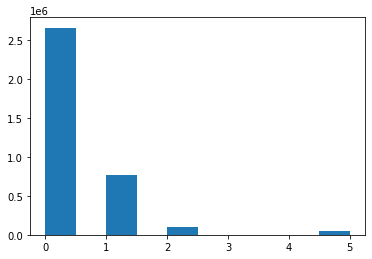

In [70]:
#histogram przed czyszczeniem danych
plt.hist(df['M_WEATHER'])

In [81]:
#preprocesing data
#z 3572328 do 532536 - usunięcie duplikatów
#z 532536 do 486142 - usunięcie dropna M_WEATHER_FORECAST_SAMPLES_M_WEATHER
#z 486142 do 475399 - usunięcie M_NUM_WEATHER_FORECAST_SAMPLES !=0
#z 475399 do 140615 - zostawienie tylko tych row, dla których M_TIME_OFFSET == 0

#cleaning data
print("Before cleaning:",str(len(df)))

df = df[columns]
df = df.dropna(subset=['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'])
df = df[df['M_NUM_WEATHER_FORECAST_SAMPLES']!=0]
df = df[df['M_TIME_OFFSET']==0.0]       
df = df.drop(['M_TIME_OFFSET'], axis=1)
df = df.drop_duplicates()
    
print("After cleaning: ",str(len(df)))

#seting column type
if(df['TIMESTAMP'].dtypes != DATATYPE):
    df['TIMESTAMP'] = df['TIMESTAMP'].apply(datetime.datetime.fromtimestamp)
df['M_SESSION_UID'] = df['M_SESSION_UID'].apply(int)
    
df

Before cleaning: 3572328
After cleaning:  140615


,TIMESTAMP,M_SESSION_UID,M_TRACK_ID,M_TRACK_TEMPERATURE,M_FORECAST_ACCURACY,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER
17038,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0
17041,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0
17048,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17115,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0
17118,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572208,2022-01-16 00:14:50,10862815468833216512,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0
3572215,2022-01-16 00:14:50,10862815468833216512,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3572282,2022-01-16 00:14:51,10862815468833216512,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,4.0,0
3572285,2022-01-16 00:14:51,10862815468833216512,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0


(array([99887.,     0.,     0.,     0.,     0., 36905.,     0.,     0.,
            0.,  3823.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

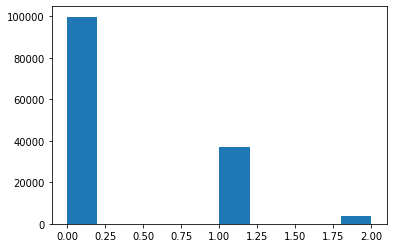

In [72]:
#hostogram po czyszczeniu danych + wnioski: Z naszej analizy wynika, że sesje, gdzie M_WEATHER===5 to gry customowe, w któych gracz ustawił const wartrtosc M_WEATHER i to sprawdza ta kolumna: M_NUM_WEATHER_FORECAST_SAMPLES
plt.hist(df['M_WEATHER'])


((140610, 5, 1, 3), (140610, 3))

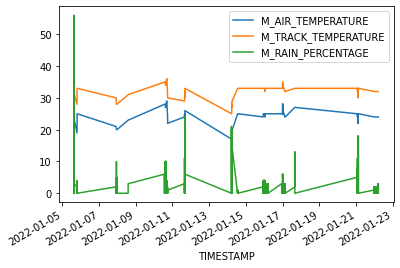

In [82]:
#LSTM - prepere data for models

df_1 = df.drop(['M_SESSION_UID'], axis=1)
df_2 = df.drop(['M_TRACK_ID'], axis=1)
df_3 = df.drop(['M_SESSION_UID', 'M_TRACK_ID'], axis=1)

df_1.index = pd.to_datetime(df_1[TIMESTAMP], format=FORMAT)
df_2.index = pd.to_datetime(df_2[TIMESTAMP], format=FORMAT)
df_3.index = pd.to_datetime(df_3[TIMESTAMP], format=FORMAT)

#fun 
def df_to_X_y(df, window_size=5):
  df_as_np =df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)



# Sesion ID (_1)




# Track ID (_2)


# ALL (_3)
temp = df_3[DECISION]
temp.plot()
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape
# number of rows = 140610 

#TODO model


In [89]:
#model variant 3 (ALL _3)

# split to train validation
X_train, y_train = X[:105458], y[:105458] #105458 rows
X_val, y_val = X[105458:123034], y[105458:123034] #17576 rows
X_test, y_test = X[123034:], y[123034:] #17576 rows

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

model1 = Sequential()
model1.add(InputLayer((12, 3)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(3, 'linear'))

model1.summary()

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

model1 = load_model('model1/')







(105458, 5, 1, 3) (105458, 3)
(17576, 5, 1, 3) (17576, 3)
(17576, 5, 1, 3) (17576, 3)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                17408     
                                                                 
 dense_16 (Dense)            (None, 8)                 520       
                                                                 
 dense_17 (Dense)            (None, 3)                 27        
                                                                 
Total params: 17,955
Trainable params: 17,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


ValueError: in user code:

    File "D:\Program Files\python\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "D:\Program Files\python\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Program Files\python\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "D:\Program Files\python\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "D:\Program Files\python\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Program Files\python\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 12, 3), found shape=(None, 5, 1, 3)
